## Defining RMSF (Root Mean Square Fluctuation)

RMSF will be defined as in the paper 'Measuring and comparing structural fluctuation patterns in large protein datasets' in the methods section.

Let the protein conformation be described in a column vector:

$$r = (r_1, r_2...)^T$$

Where each value of $r_i$ defines the position of all C$_\alpha$ atoms is: $$r_i = (x_i, y_i, z_i)^T$$

Furthermore, the mean conformation, also called native structure or equilibrium conformation in the mentioned paper, is described as:
$$\mu = <r>$$

And the fluctuation itself being:
$$\delta r = r - \mu$$

Finally leading to the definition:
$$RMSF_i = \sqrt{<\|\delta r_i\|^2>}$$

Where $\|\delta r_i\|^2 $ is defined as:

$$ \|\delta r_i\|^2 = \sqrt{(r_{xi} - \mu_x)^2 + (r_{yi} - \mu_y)^2 + (r_{zi} - \mu_z)^2} $$

Then the mean is calculated by summing over each atom in all frames and dividing by the number of frames / time, giving the following definition of $RMSF_i$:

$$ RMSF_i = \Bigg[\frac{1}{T} \sum_{t_j = 1}^{T}  (r_i(t_j) - r_i^{ref})^2 \Bigg]^{\frac{1}{2}}$$

Where (in this case) $r_i^{ref}$ is $\mu$, $r_i(t_j)$ is $r_i$, $T$ is total time or frame number and $t$ is time or frame number.

## Load the libraries needed 

In [1]:
import mdtraj as md
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import time

/Users/gil_f.hoben/anaconda/envs/MDanalysis/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/gil_f.hoben/anaconda/envs/MDanalysis/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/gil_f.hoben/anaconda/envs/MDanalysis/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/gil_f.hoben/anaconda/envs/MDanalysis/lib/python2.7/site-packages/ipykernel/pyla

## RMSF function to handle large trajectory files 

In [2]:
def _atom_selection(topology, residue_selection, selection, verbose):
    """
    Function takes a topology file and residue selection and verifies if
    the lattter is possible. It also returns the C-alpha atom selection
    Input:
        topology: 
            mdtraj.Topology or string
            Either mdtraj.Topology object or path to trajectory
            to be loaded
        residue_selection:
            string or list with integers
            String will be interpreted with the Mdtraj atom
            selection language. The list will be treated as
            atom number
        selection (by default True):
            boolean
            if true the function will try to return the residue/
            atom selection
    Output:
        atom_subset
            numpy.array 
            array with all the atom numbers corresponding to selection
        md_topology
            mdtraj.core.topology.Topology object of protein 
    """
    ## First have to load all the inputs if they are defined by a path
    if isinstance(topology, str):
        if os.path.exists(topology):
            try:
                md_topology = md.load_topology(topology)
            except:
                sys.exit('Make sure you have provided a valid path to topology file!')
            else:
                if verbose > 0:
                    print 'The following topology file was succesfully loaded: \n %s \n' %(md_topology)

    elif isinstance(topology, md.core.topology.Topology):
        md_topology = topology
        if verbose > 0:
            print 'The following topology file was succesfully loaded: \n %s \n' %(md_topology)
    else:
        sys.exit('Invalid input! Must be a valid path to topology file or mdtraj.Topology object')
    
    ## if selection is True the function will try to obtain the specified atoms/residues
    ## if residue name is specified it will by default look for C-alpha atoms
    if selection:
        if isinstance(residue_selection, list):
            try:
                atom_subset = md_topology.select(residue_selection)
            except:
                sys.exit('Invalid atom selection in list!')
            else:
                if verbose > 1:
                    print 'Your selection includes the following atom(s): \n %s \n' %(atom_subset)
                    print 'Your selection includes the following residues: \n'
                    for residue in md_topology.subset(atom_subset).residues:
                        print residue
        elif isinstance(residue_selection, str):
            try:
                atom_subset = md_topology.select('name CA and ' + residue_selection)
            except:
                sys.exit('Check if your atom selection command is recognized by the Mdtraj atom selection language!')
            else:
                if verbose > 1:
                    print 'Your selection includes the following atom(s): \n %s \n' %(atom_subset)
                    print 'Your selection includes the following residues: \n'
                    for residue in md_topology.subset(atom_subset).residues:
                        print residue
        else:
            sys.exit('Make sure you provided a valid residue selection!')
    else:
        atom_subset=md_topology.select('name CA and ' + 'all')
    
    # now that we are sure that both topology and selection are valid we can return atom_subset
    # and use the loaded topology file
    
    
    return atom_subset, md_topology

In [3]:
def _trajectory_mean(trajectories_path, chunk, top, atom_subset, first_frame, verbose):
    """
    Function takes in a trajectory and calculates the
    mean position of each atom after superimposing to reference
    Input:
        trajectories_path:
            str
            path of trajectories file of interest
        chunk:
            int
            number of frames to be loaded at a time.
            Note that this value can be defined in the main
            function.
        top:
            mdtraj.core.topology.Topology
        atom_subset:
            numpy.array
            array with all the atom numbers corresponding to selection
        first_frame:
            mdtraj.core.trajectory.Trajectory
            trajectory of first frame
        verbose:
            boolean
            if True shows more information
            Note that this value can be defined in the main
            function.
    """
    # initiating some variables...
    
    traj_sum_list=[]
    number_of_frames = 0
    
    # just a quick check to verify if path exists
    try:
        os.path.exists(trajectories_path)
    except:
        sys.exit('Make sure you have provided a string for a valid path to a trajectory file!')
    else:
        if verbose > 0:
            print 'Loading trajectories...'
    
    try:
        # now let's calculate the native conformation which
        # is just the mean position of each atom in the 
        # whole trajectory file
        for chunk_i in md.iterload(trajectories_path, chunk, top=top, atom_indices = atom_subset):
            
            # just adding the time length of chunk
            # to calculate the total simulation time
            # (not needed in calculation, just for display)
               
            
            if verbose > 1:
                print 'Successfully loaded trajectory: \n %s' %(chunk_i)

            # will use lists in this part because we don't know size
            # of matrices at this point, room for future optimization
            # first we get the sum of all atom coordinates
            # this will be achieved by column wise summation of a coordinate
            # matrix called by xyz trajectory attribute
            
            all_atom_sum =[]
            for atom in range(len(atom_subset)):
                all_atom_sum.append(chunk_i.xyz[:,atom,:].sum(axis=0))

            traj_sum_list.append(all_atom_sum)

            number_of_frames += chunk_i.xyz.shape[0]
            
    except:
        sys.exit('Error while loading trajectories! Make sure you provided a valid trajectory file!')
    
    else:
        print '\nSuccessfully loaded trajectory file!'
        if verbose > 0:
            print '\nTotal number of frames loaded: %s \n' %(number_of_frames)
    
    traj_sum_all = np.concatenate(traj_sum_list)
        
    # then we need to sum all the coordinates of all chunks together
    # we want the result to be a matrix of shape = (len(atom_subset), 3)
    all_atoms_sum_list=[]
    for atom in range(len(atom_subset)):
        all_atom_sum = traj_sum_all[atom::len(atom_subset), :].sum(axis=0)
        all_atoms_sum_list.append(all_atom_sum)
    
    # we just have to put all together
    reference_conformation_array = np.concatenate(all_atoms_sum_list)
    reference_conformation = np.reshape(reference_conformation_array, (len(atom_subset), 3))
    
    # and now we can calculate the average outside of the loop
    reference_conformation = (reference_conformation / number_of_frames) * 10
    
    # the function returns the numpy array with all coordinates
    # and the trajectory time contains the simulation time length
    return reference_conformation



In [4]:
def _fluctuation_matrix(reference_frame, trajectories_path, atom_subset, topology, chunk, first_frame):
    """
    This function computes the residual sum of squares of
    the reference frame and all the corresponding atoms
    in the provided frames
    
    Input:
        reference_frame: 
            numpy.array 
            array with the coordinates of reference frame/ 
            average conformation/ native conformation
        trajectories_path:
            str
            path of trajectories file of interest
        atom_subset:
            numpy.array
            array with all the atom numbers corresponding to selection
        topology:
            mdtraj.core.topology.Topology
        chunk:
            int
            number of frames to be loaded at a time.
            Note that this value can be defined in the main
            function.
        number_frames:
            int
            total number of frames of trajectories
        first_frame:
            mdtraj.core.trajectory.Trajectory
            trajectory of first frame        
    """
    residual_sum_squares = np.zeros((len(atom_subset)))
    
    ## now can compute the difference between the trajectory and its reference
    ## ri(t) - riref Using the mdtraj trajectory attribute xyz to extract
    ## the cartesian coordinates of trajectory and reference in a numpy array
    ## chunk.xyz.shape = (frames, atom, coordinate dimensions)
    
    
    number_of_frames=0                                
    trajectory_time=[]
    for chunk_i in md.iterload(trajectories_path, chunk = chunk, top=topology, atom_indices = atom_subset):
        trajectory_time.append(chunk_i.time)
        for atom in range(len(atom_subset)):
            diff = np.subtract(chunk_i.xyz[:, atom, :] * 10, reference_frame[atom])
            residual_sum_squares[atom] = residual_sum_squares[atom] + ((diff ** 2).sum(axis = 1).sum(axis=0))
        number_of_frames += chunk_i.xyz.shape[0]
    ## the result is a matrix with all fluctuations squared
    ## shape(number of frames * atom numbers, 3)
    ## from 0 to number of frames we have information of first atom
    ## then from number of frames to number of frames * 2 second atoms
    ## and so forth
    
    return residual_sum_squares, number_of_frames, trajectory_time


In [9]:
def rmsf_main(topology, trajectories_path, residue_selection, subunits = [], native_conformation=True, reference_frame = 0, selection=True, plot_result = True, verbose=1, chunk=100):
    """
    Compute RMSF of large trajectory files
    Input:
        topology: 
            mdtraj.Topology or string
            Either mdtraj.Topology object or path to trajectory
            to be loaded
        trajectories_path:
            trajectory file path 
            trajectories to be used for rmsf calculation
        residue_selection:
            string or list of integers
            String will be interpreted with the Mdtraj atom
            selection language. The list will be treated as
            atom number to be used for rmsf calculation
        subunits (optional):
            list
            list of tuples corresponding to start and end
            of each subunit. Needed to create subplot of 
            RMSF vs subunit
        native_conformation (optional):
            boolean (default True)
            if true it will take the mean of all coordinates 
            to calculate the 'native conformation'
            if false the reference_frame_assigned will be used
            to assign reference frame
        selection (optional, by default True)
            boolean
            if True only selection of residues will be used for RMSF,
            else all residues of mdtraj.Topology object will be used
        reference_frame (optional, default is 0):
            integer
            frame number to be used if not using native conformation method
            by default uses first frame and only is taking into account if
            native_conformation = False
        selection (optional, by default True):
            boolean
            if true the function will try to return the residue/
            atom selection 
        plot_result (optional, by default True):
            boolean
            if true the function will also return a plot of RMSF
            as a function of residue
        verbose (optional):
            interger from 0-2 (by default 1)
            level of information displayed
        chunk (optional):
            integer
            Number of frames from Trajectory file to be loaded at a time
            100 is recommended
    Output: 
        RMSF values 
            numpy.array
                each row corresponds to residue RMSF and the matrix is ordered
                by first to last residue
        RMSF plot
            matplotlib plot
                if plot_result is true a plot of the result will also be shown
        
    """
    if verbose > 0:
        # timer for the whole function
        start = time.clock()

    ## Let's start by loading the topology file
    ## Atom_subset contains information about the atom numbers
    ## we are interested in
    atom_subset, md_topology = _atom_selection(topology, residue_selection, selection, verbose)
    

    # also will use the first frame to superpose all structures
    first_frame = md.load(trajectories_path, frame=0, top=md_topology, atom_indices=atom_subset)
    
    # first have to assign the reference structure:
    # if native_conformation is True we need to calculate the the native conformation
    
    if native_conformation:
        
        try:
            # timer for reference conformation calculation and assignment
            load_start = time.clock()
            # calculate the reference conformation which is defined as the mean position of the carbon alpha atoms
            reference_conformation = _trajectory_mean(trajectories_path, chunk, md_topology, atom_subset, first_frame, verbose)
            load_end = time.clock()

        except:
            sys.exit('Did not manage to create native conformation, try using first frame as reference structure!')
        else:
            print 'Successfully created native conformation and assigned it as reference frame in %.2f seconds! \n' %(load_end - load_start)
            if verbose > 1:
                print 'C-alpha native conformation coordinates (in Å): \n%s' %(reference_conformation)
                
    # else we will just use a given frame as a reference
    # by default the first one will picked
    else:
        if reference_frame == 0:
            try:
                reference_conformation = first_frame.xyz * 10
                reference_conformation = np.reshape(reference_conformation, (reference_conformation.shape[1], 3))    
            except:
                print sys.exit('Error occured while loading first frame!')
            else:
                print 'Successfully assigned first frame as reference conformation!'
        else:
            try:
                reference_traj = md.load(trajectories_path, frame=reference_frame, top=md_topology, atom_indices=atom_subset)
                reference_conformation = reference_traj.xyz * 10
                reference_conformation = np.reshape(reference_conformation, (reference_conformation.shape[1], 3))
            except:
                print sys.exit('Error occured while assigning reference conformation!')
            else:
                print 'Successfully assigned frame %s as reference conformation!' %(reference_frame)
              
    # now we just need to subtract the native conformation to the corresponding atoms
    rmsf_matrix, number_of_frames, trajectory_time = _fluctuation_matrix(reference_conformation, trajectories_path, atom_subset, md_topology, chunk, first_frame)
    # and finally calculate the average fluctuation of each atom from
    # rmsf matrix and convert it from nm to angstrom
    # to save computing power the division and sqrt will be computed 
    # for the whole matrix outside the loop

    rmsf = (rmsf_matrix / number_of_frames) ** 0.5   
    
    if plot_result:
        max_value = max(rmsf) + 2
        # subplotting each subunit
        if len(subunits) > 0:
            f, ax = plt.subplots(figsize=(10,10), nrows= len(subunits))
            f.tight_layout()
            for i in range(len(subunits)):
                ax[i].plot(range(subunits[i][0], subunits[i][1]), rmsf[subunits[i][0]-1:subunits[i][1]-1])
                ax[i].set_title('RMSF of residues %s to %s' %(subunits[i][0], subunits[i][1]), size=15)
                ax[i].set_ylabel('RMSF (${\AA}$)')
                ax[i].set_xlabel('Residue number')
                ax[i].set_ylim([0, max_value])
            f.subplots_adjust(hspace=0.3)
        
        else:
            plt.figure(figsize=(10,10))
            plt.plot(range(1, len(atom_subset) + 1), rmsf)
            plt.title('Root mean square fluctuation', size=24)
            plt.xlabel('Residue number', size=16)
            plt.ylabel('RMSF (${\AA}$)', size =16)
            plt.ylim([0, max_value])
    
    if verbose > 0:
        total_trajectory_time = (trajectory_time[-1][-1] - trajectory_time[0][0])
        stop = time.clock()
        print '\nThe RMSF calculation took %.2f seconds.\nNumber of residues: %s \nNumber of frames: %s' %(stop - start, len(atom_subset), number_of_frames)
        print 'RMSF calculation speed: %.2f microseconds per residue per frame' %((stop - start)/len(atom_subset)/number_of_frames * 1e6)
        print 'Total simulation time of all frames: %s nanoseconds' %(total_trajectory_time / 1000)
        print 'Simulation time per frame: %s picoseconds' %(trajectory_time[0][1] - trajectory_time[0][0])
        
    return rmsf

# Author: Gil Ferreira Hoben

In [6]:
topology = '/Users/gil_f.hoben/Desktop/test/troponin_egcg_nowater_noions.prmtop'
trajectories_path = '/Users/gil_f.hoben/Desktop/test/05_Prod_troponin_egcg_MD3_0-50_run1_nowater_noions.nc'
residue_selection = 'resid 1 to 419'

In [193]:
help(rmsf_main)

Help on function rmsf_main in module __main__:

rmsf_main(topology, trajectories_path, residue_selection, subunits=[], native_conformation=True, reference_frame=0, selection=True, plot_result=True, verbose=1, chunk=100)
    Compute RMSF of large trajectory files
    Input:
        topology: 
            mdtraj.Topology or string
            Either mdtraj.Topology object or path to trajectory
            to be loaded
        trajectories_path:
            trajectory file path 
            trajectories to be used for rmsf calculation
        residue_selection:
            string or list of integers
            String will be interpreted with the Mdtraj atom
            selection language. The list will be treated as
            atom number to be used for rmsf calculation
        subunits (optional):
            list
            list of tuples corresponding to start and end
            of each subunit. Needed to create subplot of 
            RMSF vs subunit
        native_conformation (o

## MD3 complex to demonstrate the importance of choosing the reference frame

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 423 residues, 6863 atoms, 6898 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2482 

Successfully created native conformation and assigned it as reference frame in 0.70 seconds! 


The RMSF calculation took 1.88 seconds.
Number of residues: 418 
Number of frames: 2482
RMSF calculation speed: 1.81 microseconds per residue per frame
Total simulation time of all frames: 49.62 nanoseconds
Simulation time per frame: 20.0 picoseconds


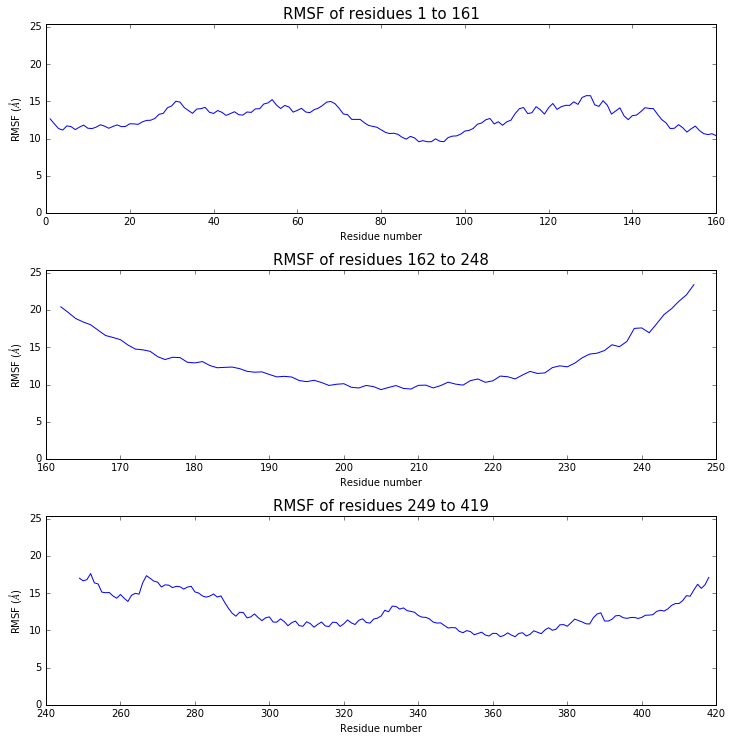

In [12]:
MD3_1 = rmsf_main(topology, trajectories_path, residue_selection, subunits=[(1,161),(162,248),(249,419)],verbose = 1, chunk=100)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 423 residues, 6863 atoms, 6898 bonds> 

Successfully assigned first frame as reference conformation!

The RMSF calculation took 1.26 seconds.
Number of residues: 418 
Number of frames: 2482
RMSF calculation speed: 1.21 microseconds per residue per frame
Total simulation time of all frames: 49.62 nanoseconds
Simulation time per frame: 20.0 picoseconds


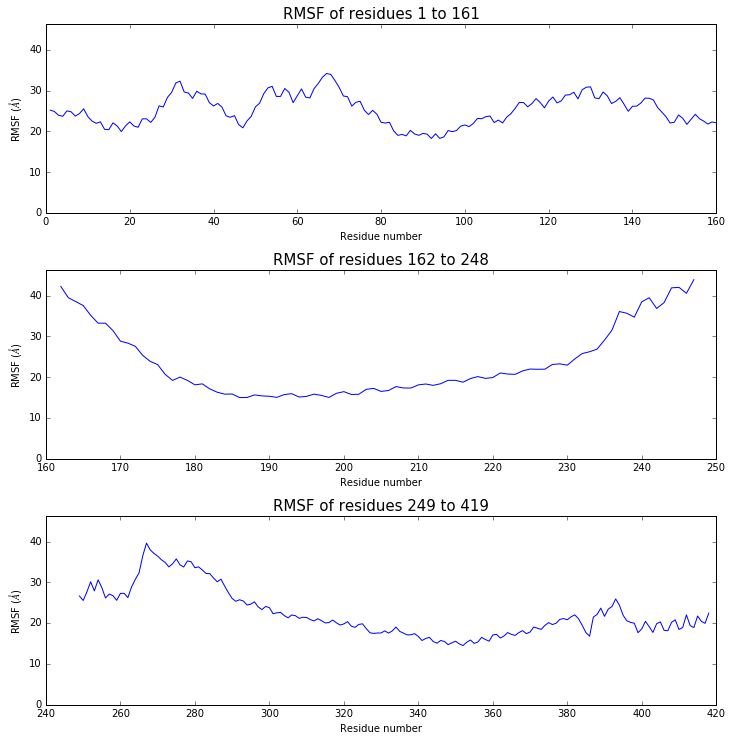

In [219]:
MD3_2 = rmsf_main(topology, trajectories_path, residue_selection,verbose = 1, native_conformation=False, subunits=[(1,161),(162,248),(249,419)])

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 423 residues, 6863 atoms, 6898 bonds> 

Successfully assigned frame 500 as reference conformation!

The RMSF calculation took 1.26 seconds.
Number of residues: 418 
Number of frames: 2482
RMSF calculation speed: 1.21 microseconds per residue per frame
Total simulation time of all frames: 49.62 nanoseconds
Simulation time per frame: 20.0 picoseconds


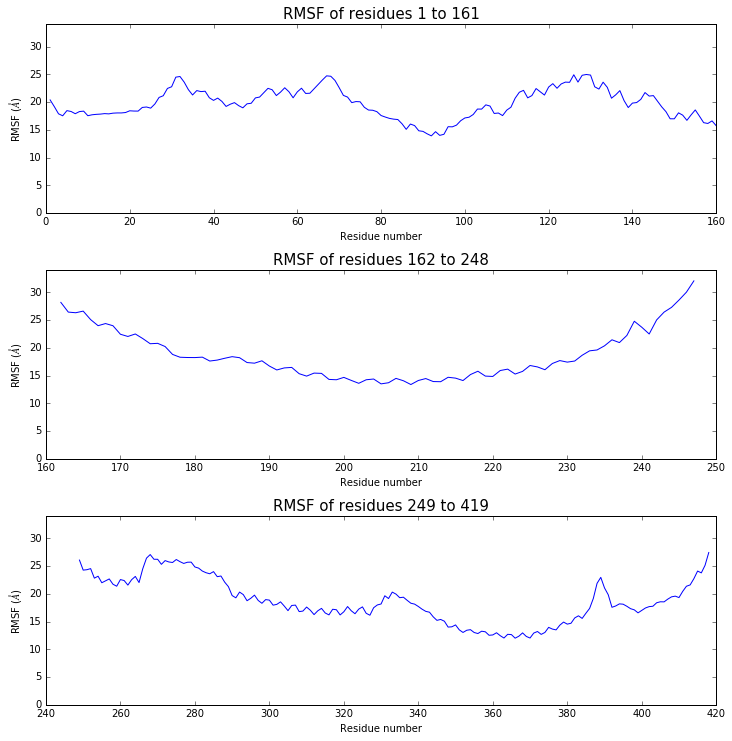

In [221]:
MD3_3 = rmsf_main(topology, trajectories_path, residue_selection,verbose = 1, native_conformation=False, subunits=[(1,161),(162,248),(249,419)], reference_frame = 500)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 423 residues, 6863 atoms, 6898 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2482 

Successfully created native conformation and assigned it as reference frame in 0.76 seconds! 


The RMSF calculation took 2.00 seconds.
Number of residues: 418 
Number of frames: 2482
RMSF calculation speed: 1.93 microseconds per residue per frame
Total simulation time of all frames: 49.62 nanoseconds
Simulation time per frame: 20.0 picoseconds


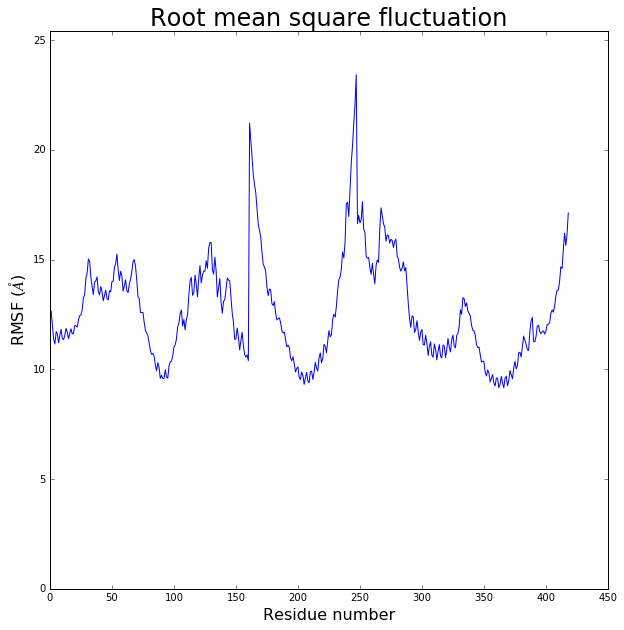

In [13]:
MD3_total = rmsf_main(topology, trajectories_path, residue_selection,verbose = 1, native_conformation=True)

## MD1 RMSF

In [252]:
topology_MD1 = '/Users/gil_f.hoben/Troponin_md/MD1/run1/000-050/troponin_egcg_MD1.prmtop'
trajectory_MD1 = '/Users/gil_f.hoben/Troponin_md/MD1/run1/000-050/05_Prod_troponin_egcg_MD1_0-50_run1.nc'
residue_selection_MD1 = 'resid 0 to 419'

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 96231 residues, 293213 atoms, 292711 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2500 

Successfully created native conformation and assigned it as reference frame in 32.66 seconds! 


The RMSF calculation took 72.26 seconds.
Number of residues: 419 
Number of frames: 2500
RMSF calculation speed: 68.98 microseconds per residue per frame
Total simulation time of all frames: 49.98 nanoseconds
Simulation time per frame: 20.0 picoseconds


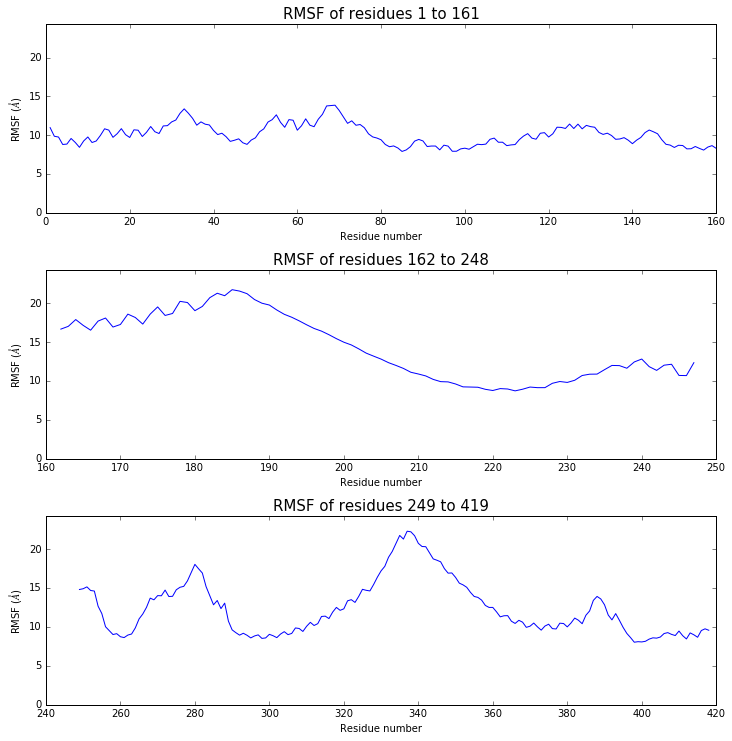

In [253]:
MD1_RMSF = rmsf_main(topology_MD1, trajectory_MD1, residue_selection_MD1, subunits=[(1,161),(162,248),(249,419)],verbose = 1)

## MD2 RMSF

In [254]:
topology_MD2 = '/Users/gil_f.hoben/Troponin_md/MD2/run1/000-050/troponin_egcg_MD2.prmtop'
trajectory_MD2 = '/Users/gil_f.hoben/Troponin_md/MD2/run1/000-050/05_Prod_troponin_egcg_MD2_0-50_run1.nc'
residue_selection_MD2 = 'resid 0 to 419'

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 110080 residues, 334760 atoms, 334258 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2488 

Successfully created native conformation and assigned it as reference frame in 36.87 seconds! 


The RMSF calculation took 81.02 seconds.
Number of residues: 419 
Number of frames: 2488
RMSF calculation speed: 77.72 microseconds per residue per frame
Total simulation time of all frames: 49.74 nanoseconds
Simulation time per frame: 20.0 picoseconds


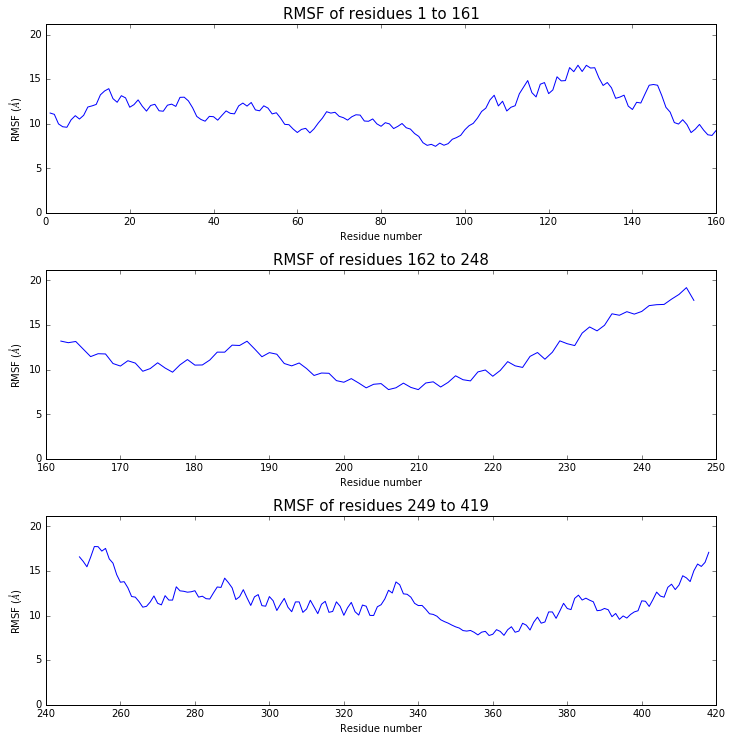

In [255]:
MD2_RMSF = rmsf_main(topology_MD2, trajectory_MD2, residue_selection_MD2, subunits=[(1,161),(162,248),(249,419)],verbose = 1)

## MD3 RMSF

In [213]:
topology_MD3 = '/Users/gil_f.hoben/Troponin_md/MD3/run1/000-050/troponin_egcg_MD3.prmtop'
trajectory_MD3 = '/Users/gil_f.hoben/Troponin_md/MD3/run1/000-050/05_Prod_troponin_egcg_MD3_0-50_run1.nc'
residue_selection_MD3 = 'resid 0 to 419'

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 114942 residues, 349346 atoms, 348844 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2482 

Successfully created native conformation and assigned it as reference frame in 39.95 seconds! 


The RMSF calculation took 86.39 seconds.
Number of residues: 419 
Number of frames: 2482
RMSF calculation speed: 83.07 microseconds per residue per frame
Total simulation time of all frames: 49.62 nanoseconds
Simulation time per frame: 20.0 picoseconds


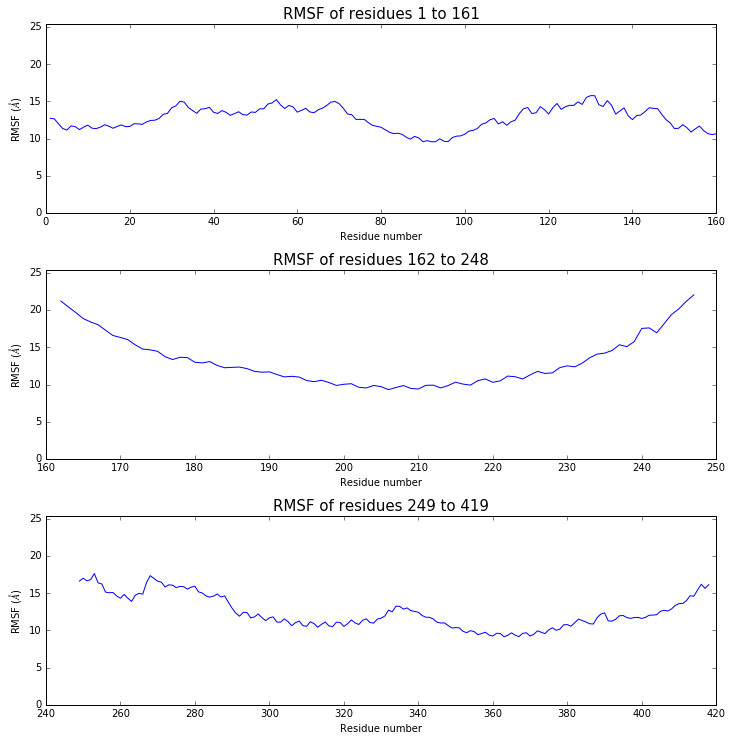

In [225]:
MD3_RMSF = rmsf_main(topology_MD3, trajectory_MD3, residue_selection_MD3, subunits=[(1,161),(162,248),(249,419)],verbose = 1)

## MD4 RMSF

In [284]:
topology_MD4 = '/Users/gil_f.hoben/Troponin_md/MD4/run1/000-050/troponin_egcg_MD4.prmtop'
trajectory_MD4 = '/Users/gil_f.hoben/Troponin_md/MD4/run1/000-050/05_Prod_troponin_egcg_MD4_0-50_run1.nc'
residue_selection_MD4 = 'resid 0 to 419'

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 110607 residues, 336341 atoms, 335839 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2500 

Successfully created native conformation and assigned it as reference frame in 38.20 seconds! 


The RMSF calculation took 85.60 seconds.
Number of residues: 419 
Number of frames: 2500
RMSF calculation speed: 81.72 microseconds per residue per frame
Total simulation time of all frames: 49.98 nanoseconds
Simulation time per frame: 20.0 picoseconds


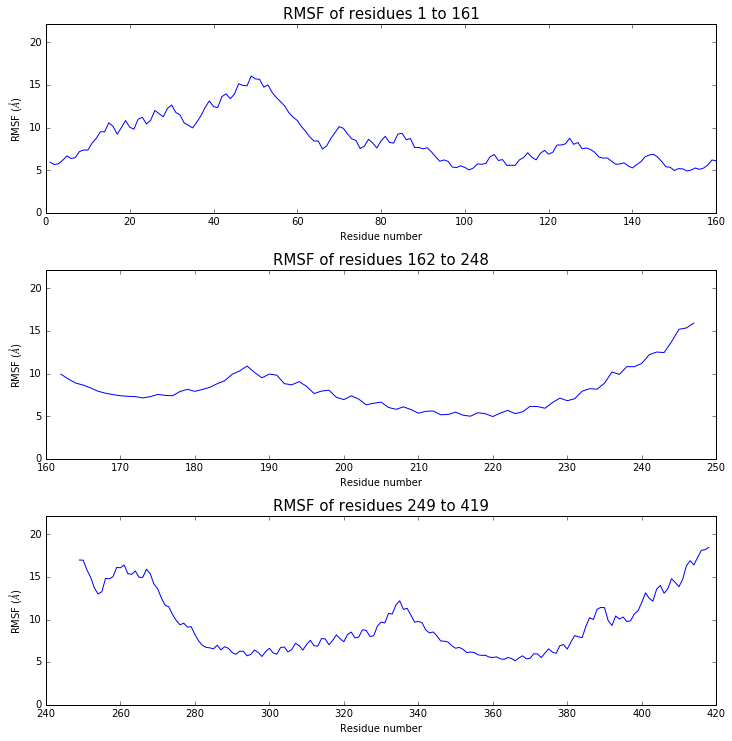

In [295]:
MD4_RMSF = rmsf_main(topology_MD4, trajectory_MD4, residue_selection_MD4, subunits=[(1,161),(162,248),(249,419)],verbose = 1)

## MD5 RMSF

In [200]:
topology_MD5 = '/Users/gil_f.hoben/Troponin_md/MD5/run1/000-050/troponin_egcg_MD5.prmtop'
trajectory_MD5 = '/Users/gil_f.hoben/Troponin_md/MD5/run1/000-050/05_Prod_troponin_egcg_MD5_0-50_run1.nc'
residue_selection_MD5 = 'resid 0 to 419'

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 96519 residues, 294077 atoms, 293575 bonds> 

Loading trajectories...

Successfully loaded trajectory file!

Total number of frames loaded: 2500 

Successfully created native conformation and assigned it as reference frame in 32.42 seconds! 


The RMSF calculation took 71.46 seconds.
Number of residues: 419 
Number of frames: 2500
RMSF calculation speed: 68.22 microseconds per residue per frame
Total simulation time of all frames: 49.98 nanoseconds
Simulation time per frame: 20.0 picoseconds


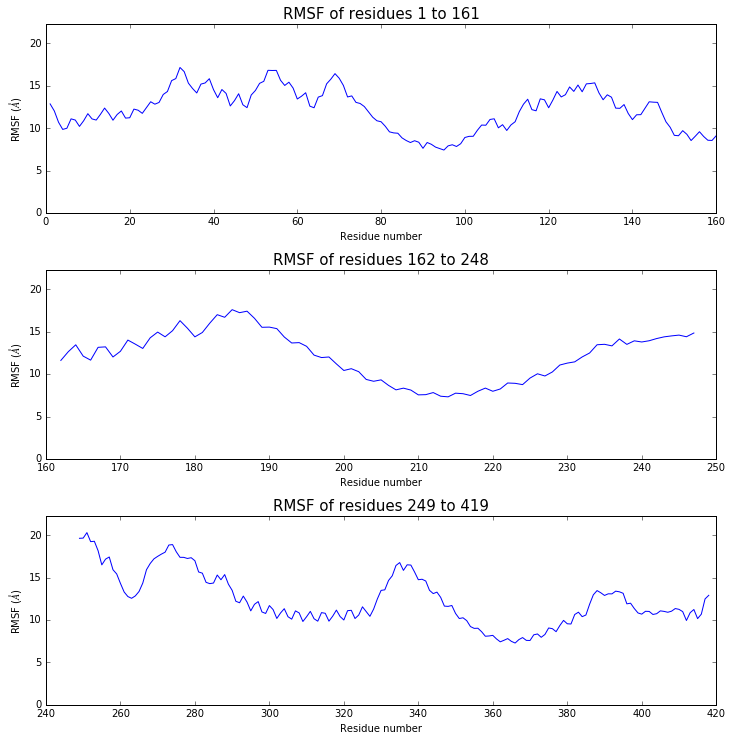

In [226]:
MD5_RMSF = rmsf_main(topology_MD5, trajectory_MD5, residue_selection_MD5, subunits=[(1,161),(162,248),(249,419)],verbose = 1)

In [297]:
RMSF_complexes = [MD1_RMSF, MD2_RMSF, MD3_RMSF, MD4_RMSF, MD5_RMSF]
RMSF_complex_names = ['MD1', 'MD2', 'MD3', 'MD4', 'MD5']
subunits=[(1,161),(162,248),(249,419)]

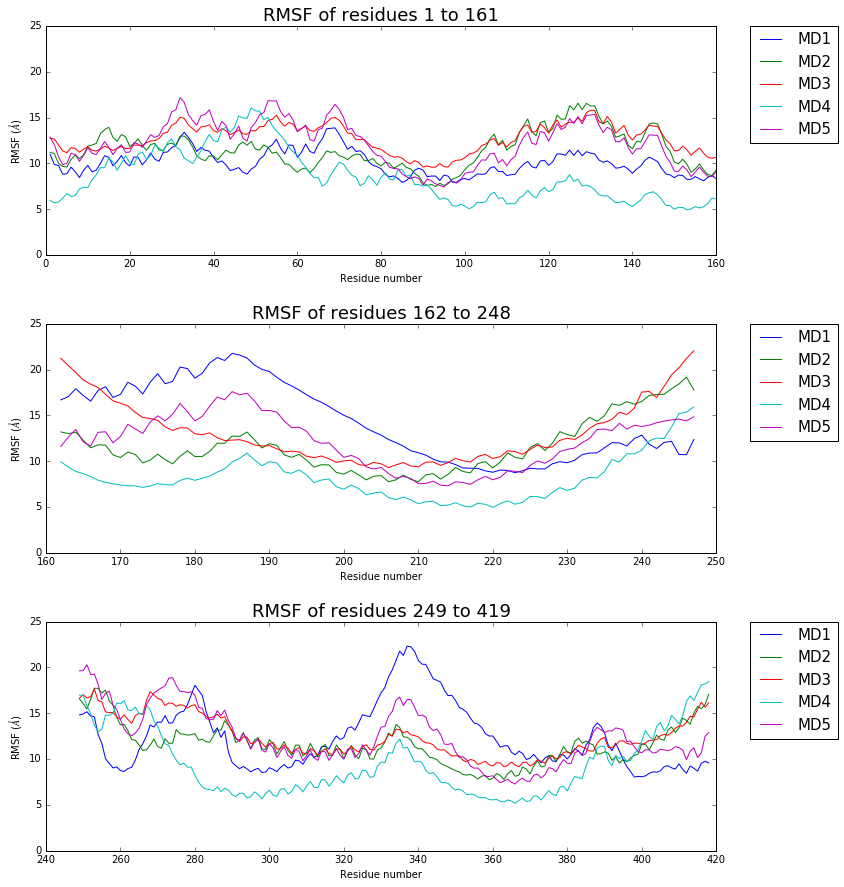

In [298]:
max_value = 25
f, ax = plt.subplots(figsize=(10,12), nrows= len(subunits))
f.tight_layout()
for j in range(len(RMSF_complexes)):
    for i in range(len(subunits)):
            ax[i].plot(range(subunits[i][0], subunits[i][1]), RMSF_complexes[j][subunits[i][0]-1:subunits[i][1]-1], label=RMSF_complex_names[j])
            ax[i].set_title('RMSF of residues %s to %s' %(subunits[i][0], subunits[i][1]), size=18)
            ax[i].set_ylabel('RMSF (${\AA}$)')
            ax[i].set_xlabel('Residue number')
            ax[i].set_ylim([0, max_value])
            # the following line was copied from the pyplot manual
            # and positions the legend box on the right side of the figure
            ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':15})
    f.subplots_adjust(hspace=0.3)